# A. Librerias y rutas

In [1]:
import os
import time
import json
import platform
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract

from browsermobproxy import Server

#from seleniumwire import webdriver
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from dotenv import load_dotenv

load_dotenv()
SENAMHI_USER = os.getenv('SENAMHI_USER')
SENAMHI_PASSWORD = os.getenv('SENAMHI_PASSWORD')

In [2]:
# 1. Definir rutas y sistema operativo
os_platform = platform.system().lower()

# Definir la carpeta de descargas para los archivos JSON
LOG_FILE_PATH = os.path.join("./scraping_log.txt")

# 2. Configurar rutas del proyecto según el sistema operativo
if os_platform == "darwin":
    BASE_PATH = "/Volumes/Projects/GitHubProjects/UNI-SCRAPING"
    CHROMEDRIVER_BASE_PATH = os.path.join(BASE_PATH, "chromedriver")
    BROWSERMOB_BASE_PATH = os.path.join(BASE_PATH, "browsermob-proxy-2.1.4")
elif os_platform == "linux":
    BASE_PATH = "/home/brew_test_gcp_01/Desktop/WallyScraper"
    CHROMEDRIVER_BASE_PATH = os.path.join(BASE_PATH, "chromedriver")
    BROWSERMOB_BASE_PATH = os.path.join(BASE_PATH, "browsermob-proxy-2.1.4")
elif os_platform == "windows":
    BASE_PATH = "D:\\GithubProjects\\Tesis\\Transparencia"
    CHROMEDRIVER_BASE_PATH = os.path.join(BASE_PATH, "chromedriver")
    BROWSERMOB_BASE_PATH = os.path.join(BASE_PATH, "browsermob-proxy-2.1.4")

if os_platform == "darwin":
    CHROMEDRIVER_PATH = os.path.join(CHROMEDRIVER_BASE_PATH, "darwin", "chromedriver")
    BROWSERMOB_PATH = os.path.join(BROWSERMOB_BASE_PATH, "bin", "browsermob-proxy")
elif os_platform == "linux":
    CHROMEDRIVER_PATH = os.path.join(CHROMEDRIVER_BASE_PATH, "linux", "chromedriver")
    BROWSERMOB_PATH = os.path.join(BROWSERMOB_BASE_PATH, "bin", "browsermob-proxy")
elif os_platform == "windows":
    CHROMEDRIVER_PATH = os.path.join(CHROMEDRIVER_BASE_PATH, "windows", "chromedriver.exe")
    BROWSERMOB_PATH = os.path.join(BROWSERMOB_BASE_PATH, "bin", "browsermob-proxy.bat")


# 3. Imprimir variables
print("ESTAMOS EN ---> ", os_platform)
print("CHROME_DRIVER_PATH: ", CHROMEDRIVER_PATH)
print("BROWSERMOB_PATH: ", BROWSERMOB_PATH)
print("")

ESTAMOS EN --->  darwin
CHROME_DRIVER_PATH:  /Volumes/Projects/GitHubProjects/UNI-SCRAPING/chromedriver/darwin/chromedriver
BROWSERMOB_PATH:  /Volumes/Projects/GitHubProjects/UNI-SCRAPING/browsermob-proxy-2.1.4/bin/browsermob-proxy



# B. Funciones

In [3]:
def get_chrome_driver(chromedriver_path=None, print_view=False, headless=False):
    # Iniciar el servidor proxy
    print(f"Iniciando servidor proxy en {os_platform}")
    server = Server(BROWSERMOB_PATH)
    server.start()
    proxy = server.create_proxy(params={'trustAllServers': 'true'})
    
    # Configurar las opciones de Selenium
    options = webdriver.ChromeOptions()
    options.add_argument("--no-sandbox")
    options.add_argument("--start-maximized")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--ignore-certificate-errors")
    options.add_argument("--proxy-server={0}".format(proxy.proxy))

    if print_view:
        options.add_argument('--disable-print-preview')
    
    if headless:
        options.add_argument("--headless=new")

    service = Service(executable_path=chromedriver_path)
    driver = webdriver.Chrome(service=service, options=options)

    return driver, server, proxy

In [4]:
def stop_dependencies(driver, server, proxy):
    driver.quit()
    server.stop()
    proxy.close()

In [5]:
def start_har(proxy):
    options = {
        'captureHeaders': True, 
        'captureContent': True, 
        'captureBinaryContent': True, 
        'captureCookies': True, 
        'captureHeadersSize': -1, 
        'captureMaxSize': -1, 
        'captureBinaryContentMaxLength': -1 
    }
    proxy.new_har("wally", options=options)

# C. Probar

## 1. Ingresar a la web

In [6]:
# leer ./results/urls.txt
with open('./results/urls.txt', 'r') as f:
    urls = f.readlines()

urls = [url.strip() for url in urls[:3]]
urls

['https://www.senamhi.gob.pe/site/descarga-datos/descarga/?cod=152204',
 'https://www.senamhi.gob.pe/site/descarga-datos/descarga/?cod=152210',
 'https://www.senamhi.gob.pe/site/descarga-datos/descarga/?cod=155105']

In [7]:
driver, server, proxy = get_chrome_driver(chromedriver_path=CHROMEDRIVER_PATH, print_view=False, headless=False)

Iniciando servidor proxy en darwin


In [8]:
driver.get(urls[0])

In [9]:
start_har(proxy)

## 2. Iniciar sesión

In [10]:
# Encontrar y hacer clic en el enlace de ingreso
login_link = driver.find_element(By.CSS_SELECTOR, 'li a[href="?p=login"]')
login_link.click()

In [11]:
# Encontrar los campos de entrada de correo y contraseña
email_input = driver.find_element(By.CSS_SELECTOR, 'input#mail')
password_input = driver.find_element(By.CSS_SELECTOR, 'input#pass')

# Ingresar credenciales desde variables de entorno
email_input.send_keys(os.getenv('SENAMHI_USER'))
password_input.send_keys(os.getenv('SENAMHI_PASSWORD'))

In [12]:
# Guardar el har
time.sleep(2)
har = proxy.har

with open('./results/har.json', 'w') as f:
    json.dump(har, f, indent=4)

## 3. Resolver captcha de inicio de sesión

URL del CAPTCHA encontrado en Selenium: https://www.senamhi.gob.pe/site/descarga-datos/include/captcha/graf_gd_genera_captcha.php?size=little


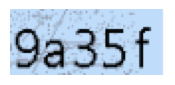

In [13]:
# Esperar que el CAPTCHA se cargue completamente
time.sleep(2)

# Buscar el elemento <img> que contiene el CAPTCHA en la página de Selenium
captcha_element = driver.find_element(By.TAG_NAME, "img")

# Obtener la URL exacta del CAPTCHA
captcha_url = captcha_element.get_attribute("src")
print(f"URL del CAPTCHA encontrado en Selenium: {captcha_url}")

# Tomar una captura de solo el CAPTCHA y guardarlo
captcha_element.screenshot("results/captcha_selenium.png")

# Mostrar la imagen del CAPTCHA en Jupyter Notebook
captcha_image = Image.open("results/captcha_selenium.png")

# Usar Matplotlib para visualizarlo en la celda
plt.figure(figsize=(2, 2))
plt.imshow(captcha_image, cmap="gray")
plt.axis("off")
plt.show()



In [14]:
# Cargar la imagen del captcha
captcha_image = Image.open("results/captcha_selenium.png")

# Usar pytesseract para convertir la imagen a texto
captcha_text = pytesseract.image_to_string(captcha_image)

print(f"Texto detectado en el CAPTCHA: {captcha_text}")

Texto detectado en el CAPTCHA: 9a35f



In [15]:
# Encontrar el campo de entrada del captcha
captcha_input = driver.find_element(By.CSS_SELECTOR, 'input#captcha')

# Limpiar cualquier texto existente y escribir el captcha detectado
captcha_input.clear()
captcha_input.send_keys(captcha_text.strip())

# Encontrar y hacer clic en el botón de inicio de sesión
login_button = driver.find_element(By.CSS_SELECTOR, 'input#envio[name="btnLogin"]')
login_button.click()

# Esperar un momento para que se procese el inicio de sesión
time.sleep(2)

## 4. Descargar

URL del CAPTCHA encontrado en Selenium: https://www.senamhi.gob.pe/site/descarga-datos/include/captcha/graf_gd_genera_captcha.php?size=little


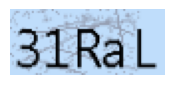

In [55]:
# Esperar que el CAPTCHA se cargue completamente
time.sleep(0.2)

# Buscar el elemento <img> que contiene el CAPTCHA en la página de Selenium
captcha_element = driver.find_element(By.TAG_NAME, "img")

# Obtener la URL exacta del CAPTCHA
captcha_url = captcha_element.get_attribute("src")
print(f"URL del CAPTCHA encontrado en Selenium: {captcha_url}")

# Tomar una captura de solo el CAPTCHA y guardarlo
captcha_element.screenshot("results/captcha_selenium.png")

# Mostrar la imagen del CAPTCHA en Jupyter Notebook
captcha_image = Image.open("results/captcha_selenium.png")

# Usar Matplotlib para visualizarlo en la celda
plt.figure(figsize=(2, 2))
plt.imshow(captcha_image, cmap="gray")
plt.axis("off")
plt.show()


In [56]:
# Cargar la imagen del captcha
captcha_image = Image.open("results/captcha_selenium.png")

# Usar pytesseract para convertir la imagen a texto
captcha_text = pytesseract.image_to_string(captcha_image)

print(f"Texto detectado en el CAPTCHA: {captcha_text}")

Texto detectado en el CAPTCHA: 31RaL



In [54]:
# Actualizar la página
#driver.refresh()

In [57]:
# Limpiar el campo de captcha por si hay un error previo
captcha_input = driver.find_element(By.ID, "captcha")
captcha_input.clear()

In [58]:
# Ingresar el nuevo captcha en el campo de texto
captcha_input.send_keys(captcha_text)

In [59]:
# Hacer clic en el checkbox de términos y condiciones
terms_checkbox = driver.find_element(By.ID, "aceptar") 
terms_checkbox.click()

In [60]:
# Hacer clic en el botón de descargar
download_button = driver.find_element(By.ID, "envio")
download_button.click()

In [34]:
stop_dependencies(driver, server, proxy)